In [2]:
import pandas as pd
import numpy as np
import yfinance as yf
import scipy.optimize as sco
import json

In [3]:
tickers = ['AMZN', 'BA', 'CAT', 'GOOGL', 'GS', 'NKE', 'NVDA', 'SOFI', 'TSLA', 'UNH']

In [4]:
# Parameters
train_start = "2021-01-01"
test_start = "2024-03-01"
test_end = "2025-01-16"
initial_capital = 50000
lookback_days = 60

# Download both Close and Open prices
data = yf.download(tickers, start=train_start, end=test_end, progress=False)
close = data['Close'].dropna()
openp = data['Open'].dropna()

# Log returns (from close prices)
log_returns = np.log(close / close.shift(1)).dropna()

# Generate monthly rebalance dates starting from test_start
rebalance_dates = pd.date_range(start=test_start, end=test_end, freq='MS')  # Month Start

# Map to actual trading days (forward-fill if it's not a trading day)
rebalance_dates = [close.index[close.index.get_indexer([d], method='bfill')[0]] for d in rebalance_dates]

# Init
weights_per_month = {}
shares_held = pd.Series(0, index=tickers)

for date in rebalance_dates:
    # Ensure date exists in index
    if date not in close.index:
        date = close.index[close.index.get_indexer([date], method='bfill')[0]]
    
    end_idx = close.index.get_loc(date)
    start_idx = end_idx - lookback_days
    if start_idx < 0:
        continue

    # Get past data window (only up to yesterday)
    window_returns = log_returns.iloc[start_idx:end_idx]
    mean_returns = window_returns.mean() * 252
    cov_matrix = window_returns.cov() * 252

    # Define Sharpe Ratio optimizer
    def neg_sharpe(weights):
        port_return = np.dot(weights, mean_returns.values)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix.values, weights)))
        return -port_return / port_vol

    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = [(0.01, 0.3)] * len(tickers)
    init_guess = np.array([1 / len(tickers)] * len(tickers))

    result = sco.minimize(neg_sharpe, init_guess, method='SLSQP',
                          bounds=bounds, constraints=constraints)
    if not result.success:
        continue

    weights = pd.Series(result.x, index=tickers)

    # Log weights
    weights_per_month[pd.to_datetime(date).strftime("%Y-%m-%d")] = weights.round(4).to_dict()
    
# Weights per Month
print(" Diversified Weights per Month:")
print(json.dumps(weights_per_month, indent=2))


YF.download() has changed argument auto_adjust default to True
 Diversified Weights per Month:
{
  "2024-03-01": {
    "AMZN": 0.1136,
    "BA": 0.01,
    "CAT": 0.3,
    "GOOGL": 0.01,
    "GS": 0.2264,
    "NKE": 0.01,
    "NVDA": 0.3,
    "SOFI": 0.01,
    "TSLA": 0.01,
    "UNH": 0.01
  },
  "2024-04-01": {
    "AMZN": 0.01,
    "BA": 0.01,
    "CAT": 0.3,
    "GOOGL": 0.1032,
    "GS": 0.2368,
    "NKE": 0.01,
    "NVDA": 0.3,
    "SOFI": 0.01,
    "TSLA": 0.01,
    "UNH": 0.01
  },
  "2024-05-01": {
    "AMZN": 0.01,
    "BA": 0.01,
    "CAT": 0.1152,
    "GOOGL": 0.3,
    "GS": 0.3,
    "NKE": 0.01,
    "NVDA": 0.1941,
    "SOFI": 0.01,
    "TSLA": 0.0265,
    "UNH": 0.0242
  },
  "2024-06-03": {
    "AMZN": 0.01,
    "BA": 0.01,
    "CAT": 0.01,
    "GOOGL": 0.3,
    "GS": 0.3,
    "NKE": 0.01,
    "NVDA": 0.129,
    "SOFI": 0.01,
    "TSLA": 0.0164,
    "UNH": 0.2047
  },
  "2024-07-01": {
    "AMZN": 0.01,
    "BA": 0.01,
    "CAT": 0.01,
    "GOOGL": 0.2002,
    "GS": 0.2475

/Users/tianze/anaconda3/envs/QF2103/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:437: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/tianze/anaconda3/envs/QF2103/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:441: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)
/Users/tianze/anaconda3/envs/QF2103/lib/python3.9/site-packages/scipy/optimize/_slsqp_py.py:495: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  a_eq = vstack([con['jac'](x, *con['args'])


In [5]:
predictions = {}
for stock in tickers:
    predictions[stock] = pd.read_csv('Predictions of ' + stock + '.csv', parse_dates=True, index_col=0)

def calculate_portfolio_value():
    portfolio_val = 50000

    historical_portfolio_value = {}

    rebalance_dates = sorted(list(weights_per_month.keys()))

    for i in range(len(rebalance_dates)):
        start_date = rebalance_dates[i]
        if i == len(rebalance_dates) - 1:
            end_date = pd.Timestamp('2025-01-16')
        else:
            end_date = rebalance_dates[i+1]

        period_start_value = portfolio_val

        trading_days = predictions[tickers[0]].loc[start_date:end_date].index

        for t in trading_days:
            daily_return = 0
            for stock in tickers:
                w = weights_per_month[start_date][stock]
                ret_diff = predictions[stock]['Cumulative_Return_Strategy'].loc[t] - predictions[stock]['Cumulative_Return_Strategy'].loc[start_date]
                daily_return += w * ret_diff
            day_value = period_start_value * (1 + daily_return)
            historical_portfolio_value[t] = day_value

        portfolio_val = list(historical_portfolio_value.values())[-1]

    return portfolio_val, historical_portfolio_value


In [6]:
def calculate_portfolio_value_equal_weights():
    portfolio_val = 50000

    historical_portfolio_value = {}

    rebalance_dates = sorted(list(weights_per_month.keys()))

    for i in range(len(rebalance_dates)):
        start_date = rebalance_dates[i]
        if i == len(rebalance_dates) - 1:
            end_date = pd.Timestamp('2025-01-16')
        else:
            end_date = rebalance_dates[i+1]

        period_start_value = portfolio_val

        trading_days = predictions[tickers[0]].loc[start_date:end_date].index

        for t in trading_days:
            daily_return = 0
            for stock in tickers:
                w = 0.1
                ret_diff = predictions[stock]['Cumulative_Return_Strategy'].loc[t] - predictions[stock]['Cumulative_Return_Strategy'].loc[start_date]
                daily_return += w * ret_diff
            day_value = period_start_value * (1 + daily_return)
            historical_portfolio_value[t] = day_value

        portfolio_val = list(historical_portfolio_value.values())[-1]

    return portfolio_val, historical_portfolio_value


In [7]:
def calculate_portfolio_value_benchmark():
    # Initial portfolio value is defined once.
    initial_portfolio_value = 50000
    benchmark_portfolio_value = {}

    # Use the first available date as the buy date.
    start_date = predictions[tickers[0]].index[0]

    # Loop through all trading days based on one of the DataFrames.
    for t in predictions[tickers[0]].index:
        daily_return = 0
        for stock in tickers:
            weight = 0.1  # each stock is weighted equally at 10%
            print(stock)
            ret_diff = (predictions[stock]['Cumulative_Benchmark_Return'].loc[t] -
                        predictions[stock]['Cumulative_Benchmark_Return'].loc[start_date])
            daily_return += weight * ret_diff
        benchmark_portfolio_value[t] = initial_portfolio_value * (1 + daily_return)

    final_value = list(benchmark_portfolio_value.values())[-1]
    return final_value, benchmark_portfolio_value


AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SOFI
TSLA
UNH
AMZN
BA
CAT
GOOGL
GS
NKE
NVDA
SO

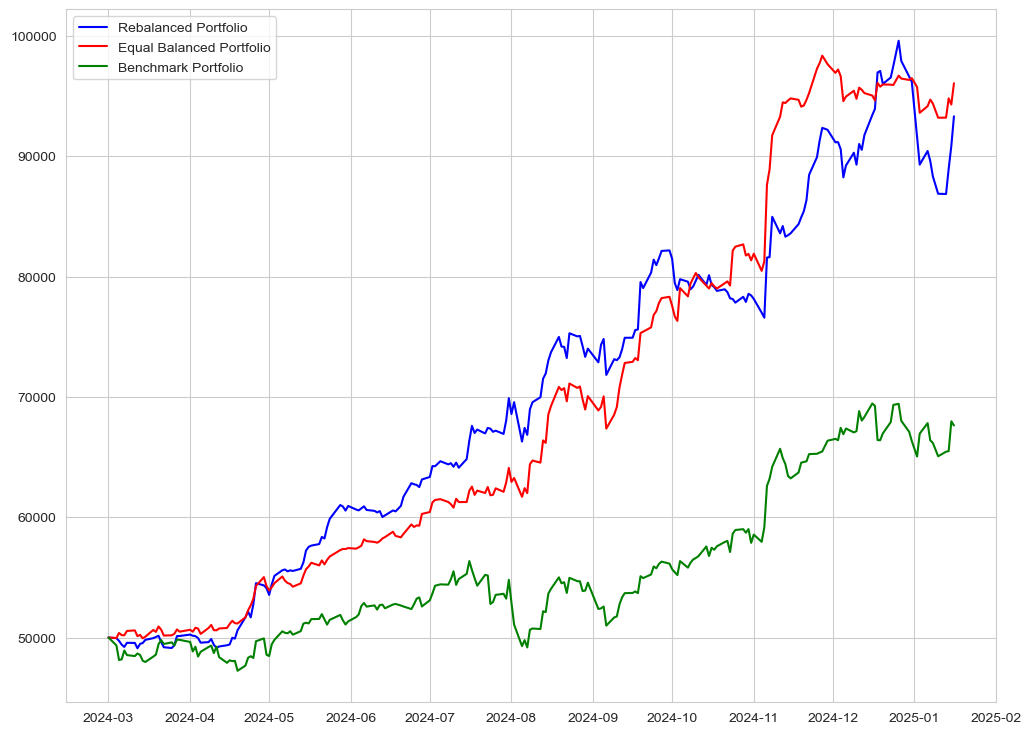

In [8]:
import matplotlib.pyplot as plt
final_rebalanced_value, rebalanced_values_historical = calculate_portfolio_value()
final_equal_weights_value, equal_weight_values_historical = calculate_portfolio_value_equal_weights()
final_benchmark_value, benchmark_values_historical = calculate_portfolio_value_benchmark()

dates = rebalanced_values_historical.keys()
rebalanced_values = [rebalanced_values_historical[date] for date in dates]
equal_weight_strategy_values = [equal_weight_values_historical[date] for date in dates]
benchmark_values = [benchmark_values_historical[date] for date in dates]

plt.figure(figsize=(12,9))
plt.plot(dates, rebalanced_values, c='b', label='Rebalanced Portfolio')
plt.plot(dates, equal_weight_strategy_values, c='r', label='Equal Balanced Portfolio')
plt.plot(dates, benchmark_values, c='g', label='Benchmark Portfolio')
plt.legend()
plt.show()

In [9]:
predictions['AMZN']['Returns']

Date
2024-03-01    0.008260
2024-03-04   -0.003591
2024-03-05   -0.019484
2024-03-06   -0.003503
2024-03-07    0.019077
                ...   
2025-01-10   -0.014361
2025-01-13   -0.002192
2025-01-14   -0.003204
2025-01-15    0.025671
2025-01-16   -0.012044
Name: Returns, Length: 221, dtype: float64

In [10]:
final_rebalanced_value, final_equal_weights_value, final_benchmark_value

(93317.6497508058, 96066.66055378849, 67622.34321907314)